# Logistic Regression:

This Jupyter Notebook is dedicated to understanding and implementing the logistic regression on a single neuron for soccer data. You can find the dataset [2022-2023 Soccer Player Stats Dataset](https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats?resource=download).

The following packages are required to run the attached code:

- [Pandas](https://pandas.pydata.org/docs/)

- [Matplotlib.pylab](https://matplotlib.org/2.0.2/api/pyplot_api.html)

- [Numpy](https://numpy.org/doc/)

- [Seaborn](https://seaborn.pydata.org/)

## Description of the Algorithm:

***
In a previous notebook, I implemented the single neuron perceptron algorithm. This algorithm worked great for binary classification, but it only works when dividing the data linearly. For more complex data that cannot be split linearly, we can use logistic regression!



***

## Setting Up:

***
Import the necessary modules.
***

In [57]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import numpy as np
import pandas as pd
import seaborn as sns

***
Read in the data. We will be using shots as the predictor and goals as the response.
***

In [58]:
#Import the dataset. 
soccer = pd.read_csv("/Users/pstern/Desktop/INDE-577/Datasets/soccer_stats.csv", encoding='ISO-8859-1', delimiter=';')

# Filter the data such that we are only including players who have player more than 15 games worth of time.
soccer = soccer[soccer['90s'] >= 15.0]

# Just use the first 250 data points.
data = soccer[:250]

# Filter the data to only include players who have received a red card.
reds = soccer[soccer['Goals'] > 0]
no_reds = soccer[soccer['Goals'] == 0]

# Select fouls as a predictor.
g_t = reds[['Touches']].values
ng_t = no_reds[['Touches']].values

# Select yellow cards as a predictor.
g_s = reds[['SoT']].values
ng_s = no_reds[['SoT']].values

# Current best: Touches, SoT, Red Cards


***
Plot the data to determine if we can, in fact, perform binary classification.
***

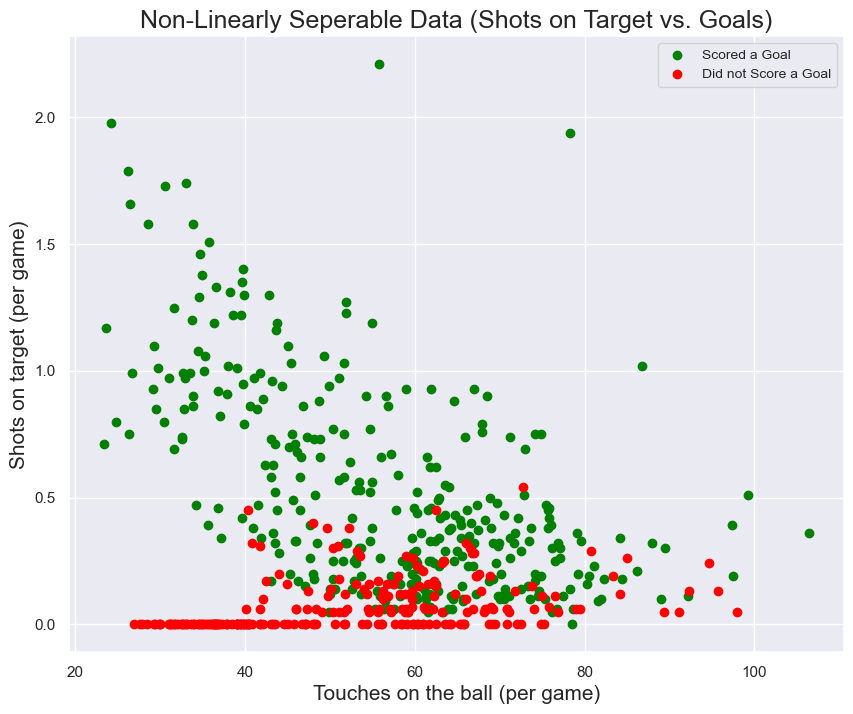

In [59]:
# Set the theme. 
sns.set_theme()

plt.figure(figsize = (10, 8))

# Add the red card players to the plot.
plt.scatter(g_t, g_s, color = "green", label = "Scored a Goal")

# Add the non red card players to the plot.
plt.scatter(ng_t, ng_s, color = "red", label = "Did not Score a Goal")
plt.xlabel("Touches on the ball (per game)", fontsize = 15)
plt.ylabel("Shots on target (per game)", fontsize = 15)
plt.legend(fontsize = 10, loc = "upper right")
plt.title("Non-Linearly Seperable Data (Shots on Target vs. Goals)", fontsize = 18)
plt.show()

Note that the split in the data is not extrememly clear and there is some overlap. I am curious to see how the algorithm handles this. 

***
Also, plot shots on target vs. goals for when we do logistic regression on a single variable. 
***

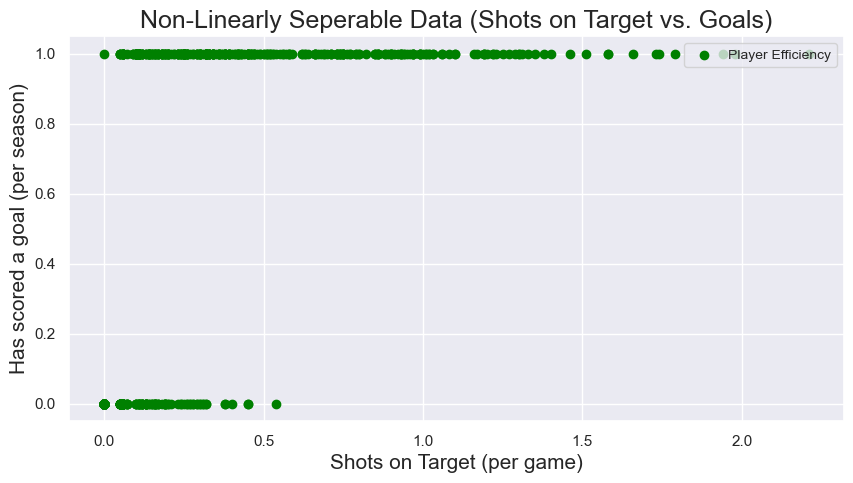

In [60]:
# Set the theme. 
sns.set_theme()

# Set the figure size. 
plt.figure(figsize = (10, 5))

# Get the predictor and response.
x = soccer['SoT'].values
x = x.reshape(-1, 1)
y = np.where(soccer['Goals'] > 0, 1, 0)

# Add the red card players to the plot.
plt.scatter(x, y, color = "green", label = "Player Efficiency")
plt.xlabel("Shots on Target (per game)", fontsize = 15)
plt.ylabel("Has scored a goal (per season)", fontsize = 15)
plt.legend(fontsize = 10, loc = "upper right")
plt.title("Non-Linearly Seperable Data (Shots on Target vs. Goals)", fontsize = 18)
plt.show()

Again, we can clearly see some overlap in the data as x values do not seem to be a perfect indicator of if a player has scored a goal. 

## Let's try to do the Split with Perceptron:

***
Analyze the data.
***

The data isn't perfectly split, but it's hard to find something that is perfect in soccer data because of things like corners, free kicks, and penalties where many players tend to score. This will just have to be a challenge for the logistic regression algorithm!

In this set, there seems to be a clear trend in where each set of data lies (the non-goal players have a varying number of touches but very few shots on target), while the goal scoring playes have a varying number of touches but larger numbers of shots on target. 

There also doesn't seem to be a viable linear split as, for the non-goal scoring players, there seems to be a swell in shots on target when there are between 40 and 80 touches per game, which is non-linear. If we used the perceptron algorithm, as you will see below, it would not fully capture the spread ofthe data. 

***
Implement the perceptron algorithm for comparison. We will use shots on target as a predictor for goals. 
***

In [61]:
# Implement a class to perform the perceptron algorithm.
class Perceptron(object):
    # Initialize Perceptron object.
    def __init__(self, eta = .5, epochs=50):
        self.eta = eta
        self.epochs = epochs
        
    def train(self, X, y):
        # Initialize random weights.
        self.weight = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        
        # Iterate through the epochs.
        for _ in range(self.epochs):
            errors = 0

            # Iterate through each sample in the training set.
            for xi, target in zip(X, y):

                # Update weights based on the difference between predicted and actual class.
                update = self.eta * (self.predict(xi) - target)
                self.weight[:-1] -= update * xi
                self.weight[-1] -= update

                #Keep track of the number of errors.
                errors += int(update != 0)

            # If there are no errors in this epoch, return.
            if errors == 0:
                return self
            else:
                self.errors_.append(errors)
            
        return self
    
    def net_input(self, X):
        # Calculate net input (sum of weighted inputs plus bias).
        return np.dot(X, self.weight[:-1]) + self.weight[-1]
    
    def predict(self, X):
        # Predict class labels based on net input.
        return np.where(self.net_input(X) >= 0.0, 1, -1)

***
Let's get the prediction error using perceptron. Do we even need logistic regression?
***

In [67]:
# Instantiate an instance of the Perceptron class.
ptron = Perceptron(epochs = 500)

# Train the model.
ptron.train(x, y)

# Predict make predictions based on training.
y_hat = ptron.predict(x)

# Compare our predictions with reality.
sum = 0
for i in range(len(y_hat)):
    if y_hat[i] != y[i]:
        sum += 1

print(f"Error Percent = {round(((sum / len(y_hat)) * 100), 2)}%")


Error Percent = 58.27%


This is clearly not good as our predictions were only accurate for our data as it made the wrong prediction 58% of the time. We can do better with logistic regression!

## Description of the Logistic Regression algorithm:

***
To account for non linearity, we go from predicting class as a binary to defining a probability for it being in each class using a single neuron model.

For logistic regression, we use the sigmoid activation function instead of just a simple linear one. This function is of the form $\sigma (z)  = 1 / (1 + e^{-z})$. This function is well equipped to handle non-linear binary classification because the sigmoid function has a range of (0,1), the exact values we look for when dealing with probabilities. Further, the sigmoid function is s-shaped allowing it to better capture more complex data that cannot just be separated linearly. 
***

## Deriving the Logistic Regression Model:

## Implementing Logistic Regression:

***
Implement the single neuron model for logistic regression. We will use shots on target as the predictor for goals. 
***

In [63]:
class SingleNeuron(object):
    # Initialize the class objects.
    def __init__(self, activation_function, cost_function):
        self.activation_function = activation_function
        self.cost_function = cost_function

    # Train the model. 
    def train(self, X, y, alpha = 0.005, epochs = 50):
        self.w_ = np.random.rand(1 + X.shape[1])
        self.errors_ = []
        N = X.shape[0]

        #Iterate through the epochs.
        for _ in range(epochs):
            errors = 0
            for xi, target in zip(X, y):
                error = (self.predict(xi) - target)
                self.w_[:-1] -= alpha*error*xi
                self.w_[-1] -= alpha*error
                errors += self.cost_function(self.predict(xi), target)
            self.errors_.append(errors/N)
        return self

    # Predict the output.
    def predict(self, X):
        preactivation = np.dot(X, self.w_[:-1]) + self.w_[-1]
        return self.activation_function(preactivation)

    # Plot the cost function.
    def plot_cost_function(self):
        fig, axs = plt.subplots(figsize = (10, 8))
        axs.plot(range(1, len(self.errors_) + 1), 
                self.errors_,
                label = "Cost function")
        axs.set_xlabel("epochs", fontsize = 15)
        axs.set_ylabel("Cost", fontsize = 15)
        axs.legend(fontsize = 15)
        axs.set_title("Cost Calculated after Epoch During Training", fontsize = 18)
        plt.show()

    # Plot the decision boundary.
    def plot_decision_boundary(self, X, y, xstring="x", ystring="y"):
        plt.figure(figsize = (10, 8))
        plot_decision_regions(X, y, clf = self)
        plt.title("Neuron Decision Boundary", fontsize = 18)
        plt.xlabel(xstring, fontsize = 15)
        plt.ylabel(ystring, fontsize = 15)
        plt.show()

def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def cross_entropy_loss(y_hat, y):
    return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)

node = SingleNeuron(sigmoid, cross_entropy_loss)

x = soccer['SoT'].values
x = x.reshape(-1, 1)
y = np.where(soccer['Goals'] > 0, 0, 1)

node.train(x, y, alpha = 0.01, epochs = 2000)

***
Let's visualize the "cost" at each epoch to see if our algorithm is improving at each epoch.
***

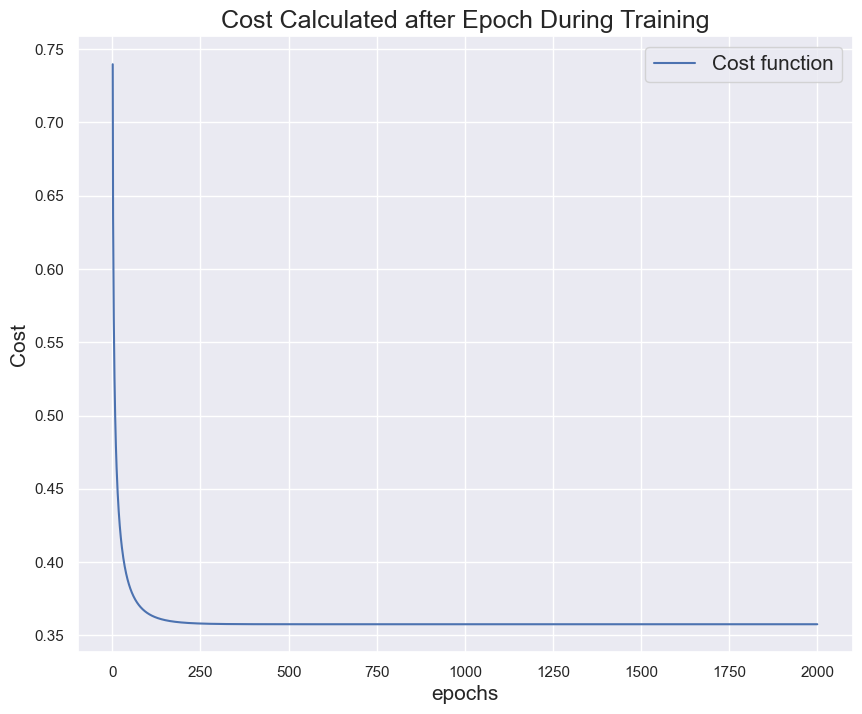

In [64]:
node.plot_cost_function()
plt.show()

The cost decreases rapidly in the first 100 epochs and then slowed afterwards. I initally ran the training data for 10,000 epochs but substantial change seemed to stop after the first 2000.

***
Now, let's get the error percent for logistic regression.
***

In [65]:
y_hat = node.predict(x)

np.rint(y_hat) != y

error = (np.rint(y_hat) != y).astype(int)
print(f"Error Percent = {round(((error.sum() / len(y)) * 100), 2)}%")

Error Percent = 17.43%


We are now doing much better! A 17% error rate isn't perfect, but given the amount of overlap between the groups in the data (see the first graph), I am quite impressed with the effectiveness of logistic regression.

***
Let's plot the decision boundary to get a better look at the split. 
***

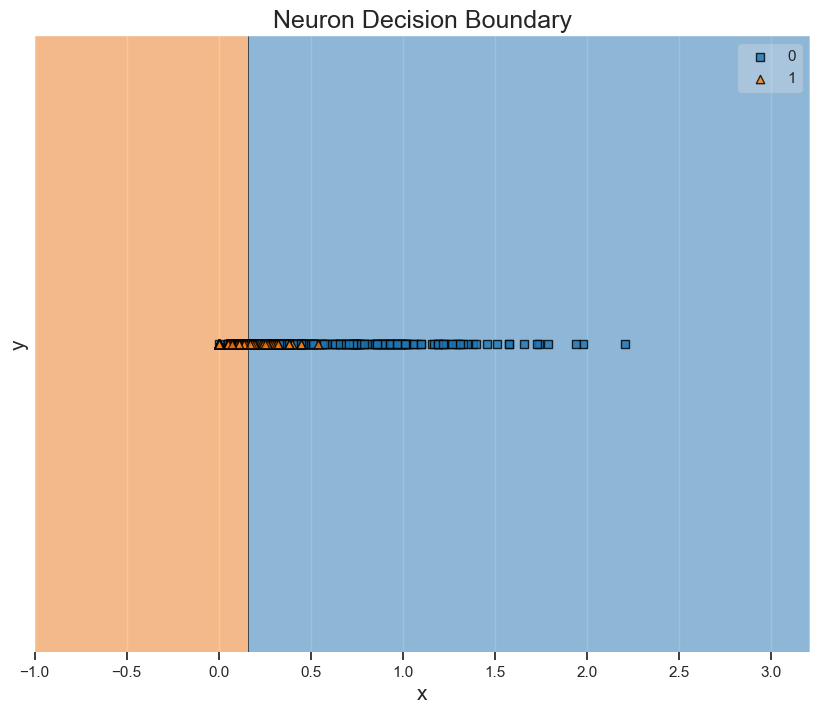

In [66]:
node.plot_decision_boundary(x, y)
plt.show()

Again, there is definitely some overlap, but generally, the model does well.

## We can also do single neuron logistic regression with multiple inputs:

***
Now we will use both touches and shots on target as predictors. 
***

In [84]:
# Instantiate a new single neuron.
mul_node = SingleNeuron(sigmoid, cross_entropy_loss)

# Get the predictor data.
mul_X = soccer[['Touches','SoT']].values

# Train the new single neuron model on the new feature vectors.
mul_node.train(mul_X, y, alpha = 0.01, epochs = 100)

print(mul_node.errors_)

'''
plt.figure(figsize = (10, 8))
#plt.plot(range(1, len(node.errors_) + 1), node.errors_, label = "node Cross Entropy Loss")
plt.plot(range(1, len(mul_node.errors_) + 1), mul_node.errors_, label = " mul_node Cross Entropy Loss")
plt.xlabel("epochs", fontsize = 15)
plt.ylabel("Cross Entropy Loss", fontsize = 15)
plt.legend(fontsize = 15)
plt.title("Model Cost Comparison During Training", fontsize = 18)

plt.show()
'''

/var/folders/qh/d1v3c1xj1ng1h6dw103g_2f40000gn/T/ipykernel_18715/3131494931.py:54: RuntimeWarning: divide by zero encountered in log
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)
/var/folders/qh/d1v3c1xj1ng1h6dw103g_2f40000gn/T/ipykernel_18715/3131494931.py:54: RuntimeWarning: invalid value encountered in scalar multiply
  return - y*np.log(y_hat) - (1 - y)*np.log(1 - y_hat)


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


'\nplt.figure(figsize = (10, 8))\n#plt.plot(range(1, len(node.errors_) + 1), node.errors_, label = "node Cross Entropy Loss")\nplt.plot(range(1, len(mul_node.errors_) + 1), mul_node.errors_, label = " mul_node Cross Entropy Loss")\nplt.xlabel("epochs", fontsize = 15)\nplt.ylabel("Cross Entropy Loss", fontsize = 15)\nplt.legend(fontsize = 15)\nplt.title("Model Cost Comparison During Training", fontsize = 18)\n\nplt.show()\n'